# Project 4: CG, BFGS and SR1

In [1]:
import numpy as np
from numpy.linalg import norm, solve, multi_dot
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

In [2]:
# Hilbert matrix
from scipy.linalg import hilbert

In [3]:
# Laplacian matrix
def laplacian(n):
    m = np.zeros([n, n])
    for i in range(n):
        m[i, i] = 2 
        if i > 0:
            m[i, i - 1] = -1 
        if i < n-1:
            m[i, i + 1] = -1
    return m

### Task 1: Conjudate Gradient Method

In [4]:
def CG(A, b):
    n = A.shape[0]
    x = np.matrix(np.zeros([n, 1])) 
    r = A * x - b
    p = -r
    k = 0
    while norm(r) > 1e-16 and k < n:
        q     = A * p
        t     = (p.T * q)
        alpha = np.asscalar(-(r.T * r) / t)  
        x     = x + alpha * p 
        rs    = r
        r     = r + alpha * q 
        beta  = np.asscalar((r.T * r) / (rs.T * rs))
        p     = -r + beta * p 
        k     = k + 1
    return x, k, norm(r)

In [5]:
# call this function to print out the results.

def comparison(cg_method, matrix_type):
    for n in [2**i for i in range(6)]:
        A = matrix_type(n) 
        b = np.ones([n, 1])
        x, iter_number, err = cg_method(A, b) 
        x_system            = np.linalg.solve(A, b) 
        err_system          = norm(A @ x_system - b) 
        print("n: {N}\t CG iter:{ITER}\t error:{ERR:6.2e}\t built-in error:{ERRSYS:6.2e}".format(
            N=n, ITER=iter_number,ERR=err, ERRSYS=err_system))

In [6]:
comparison(CG, hilbert)

n: 1	 CG iter:1	 error:2.00e+00	 built-in error:0.00e+00
n: 2	 CG iter:2	 error:3.82e+00	 built-in error:0.00e+00
n: 4	 CG iter:4	 error:7.57e+00	 built-in error:6.15e-15
n: 8	 CG iter:8	 error:1.52e+01	 built-in error:7.10e-12
n: 16	 CG iter:16	 error:3.08e+01	 built-in error:2.14e-08
n: 32	 CG iter:32	 error:6.23e+01	 built-in error:1.45e-07


In [7]:
comparison(CG, laplacian)

n: 1	 CG iter:1	 error:2.00e+00	 built-in error:0.00e+00
n: 2	 CG iter:2	 error:3.77e+00	 built-in error:0.00e+00
n: 4	 CG iter:4	 error:9.42e+00	 built-in error:1.09e-15
n: 8	 CG iter:8	 error:2.51e+01	 built-in error:3.55e-15
n: 16	 CG iter:16	 error:6.82e+01	 built-in error:1.35e-14
n: 32	 CG iter:32	 error:1.87e+02	 built-in error:4.85e-14


### Task 2: BFGS and SR1

In [8]:
tol = 1e-9

def exact_line_search_quasi_newton(update_method, x0, H0):
    k = 0
    xcoords = [x0[0]]
    ycoords = [x0[1]]
    x_k = x0 
    H_k = H0 
    g_k = grad_objective_func(x_k)
    while norm(g_k) > tol:
        p_k = -np.matmul(H_k, g_k)                # search direction
   
        def subproblem1D(alpha):                  # for exact line search
            return objective_func(x_k + alpha * p_k)
        
        res = minimize_scalar(subproblem1D)
        alpha_k = res.x 

        s_k     = alpha_k * p_k                   # s_k = x_{k+1} - x_k 
        g_k1    = grad_objective_func(x_k + s_k)  # gk1 is g_{k+1}
        y_k     = g_k1 - g_k                      # y_k = g_{k+1} - g_(k)
        
        k = k + 1                                 # increment
        H_k = update_method(H_k, s_k, y_k).A      
        x_k = x_k + s_k 
        g_k = g_k1
        
        xcoords.append(x_k[0])
        ycoords.append(x_k[1])
        
    return x_k, k, norm(g_k), xcoords, ycoords

In [9]:
# SR1 Algorithm

def SR1(H, s_k, y_k):
    z = s_k - np.dot(H, y_k) 
    # the numerator is a matrix!
    numer = np.matrix(z).T * np.matrix(z)
    denom = np.dot(z, y_k)
    # when the denominator is too small, we skip the iteration.
    if np.abs(denom) < 10**(-8) * norm(z) * norm(y_k):
        return H
    else:
        return H + numer/denom 

In [10]:
# BFGS Algorithm

def BFGS(H, s_k, y_k):
    I = np.eye(H.shape[0])
    y_vec = y_k[:, None] # want to vectorize for matrix multiplication
    s_vec = s_k[:, None]
    rho = 1/ np.dot(y_k,s_k) # this is a scalar so multiply with array form
    l = I - rho*np.dot(s_vec, y_vec.T)
    r = I - rho*np.dot(y_vec, s_vec.T)
    H = multi_dot([l,H,r]) + rho*np.dot(s_vec,s_vec.T)
    return np.matrix(H)

In [11]:
# Newton's Method with backtracking

def backtracking(objective_func,grad_objective_func,pk,xk,c1,rho):
    alpha = 1
    while objective_func(xk + alpha*pk) > objective_func(xk) + c1*alpha*np.dot(pk.T,grad_objective_func(xk)):
        alpha = rho*alpha
    return alpha

def newton_method(x0):                      # input is the starting point
    x = x0                                  # select the starting point
    p = -grad_objective_func(x)             # find descent direction
    h = hessian_func(x)                     # find hessian matrix
    i = 0
    while norm(p) > 1e-9:                   # if the norm is not small
        alpha = backtracking(objective_func,grad_objective_func,p,x,1e-4,0.9)
                                            # Using backtracking alpha
        newton_dir = np.linalg.solve(h, p)  # Newton direction
        x = x + alpha*newton_dir            # locate the next iterate
        p = -grad_objective_func(x)         # find next descent direction
        h = hessian_func(x)                 # find next hessian matrix
        i += 1
    print(i,"Iteration")   
    return x

### Testing on Rosenbrock function

In [12]:
# Rosenbrock Function 
def objective_func(x):
    return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

def grad_objective_func(x):
    return np.array([-400 * x[0] * (x[1] - x[0] ** 2) - 2 * (1 - x[0]), 200 * (x[1] - x[0]**2)])

def hessian_func(x):
    return np.matrix([[-400*(x[1] - 3*x[0]**2) + 2, -400 * x[0]], [-400 * x[0], 200]])

In [13]:
# Starting point at (1.2, 1.2)
x0 = np.array([1.2, 1.2])
H0 = np.eye(2)

In [14]:
# Using Newton's Method
newton_method(x0)

13734 Iteration


array([1., 1.])

The iteration numbers for SR1 at starting point [1.2 1.2] is 10
Minimizer: [1. 1.]


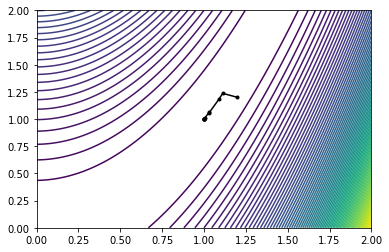

In [15]:
# Using SR1

x, iter_number, err, xcoords, ycoords = exact_line_search_quasi_newton(SR1, x0, H0)
print("The iteration numbers for SR1 at starting point", x0, "is", iter_number)
print("Minimizer:", x)

x = np.linspace(0, 2, 500)
y = np.linspace(0, 2, 500)
X, Y = np.meshgrid(x, y)

# evaluate function
Z = objective_func([X,Y])

plt.contour(X, Y, Z, 90);
plt.plot(xcoords, ycoords, '-k', marker='.')
plt.show()

The iteration numbers for BFGS at starting point [1.2 1.2] is 10
Minimizer: [1. 1.]


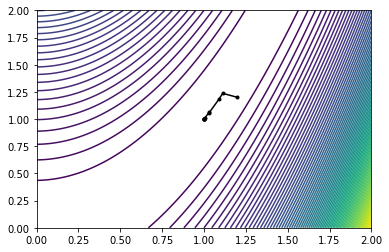

In [16]:
# Using BFGS

x, iter_number, err, xcoords, ycoords = exact_line_search_quasi_newton(BFGS, x0, H0)
print("The iteration numbers for BFGS at starting point", x0, "is", iter_number)
print("Minimizer:", x)

x = np.linspace(0, 2, 500)
y = np.linspace(0, 2, 500)
X, Y = np.meshgrid(x, y)

# evaluate function
Z = objective_func([X,Y])

plt.contour(X, Y, Z, 90);
plt.plot(xcoords, ycoords, '-k', marker='.')
plt.show()

In [17]:
# Starting point at (-1.2, 1)
x0 = np.array([-1.2, 1])
H0 = np.eye(2)

In [18]:
# Using Newton's Method
newton_method(x0)

5644 Iteration


array([1., 1.])

The iteration numbers for SR1 at starting point [-1.2  1. ] is 22
Minimizer: [1. 1.]


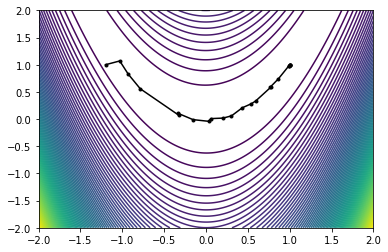

In [19]:
# Contour plot of objective function using SR1

x, iter_number, err, xcoords, ycoords = exact_line_search_quasi_newton(SR1, x0, H0)
print("The iteration numbers for SR1 at starting point", x0, "is", iter_number)
print("Minimizer:", x)

x = np.linspace(-2, 2, 500)
y = np.linspace(-2, 2, 500)
X, Y = np.meshgrid(x, y)

# evaluate function
Z = objective_func([X,Y])

plt.contour(X, Y, Z, 90);
plt.plot(xcoords, ycoords, '-k', marker='.')
plt.show()

The iteration numbers for BFGS at starting point [-1.2  1. ] is 22
Minimizer: [1. 1.]


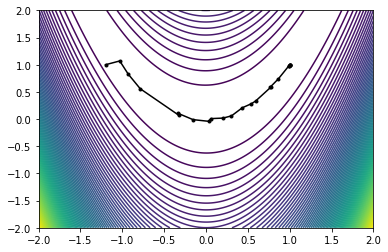

In [20]:
x, iter_number, err, xcoords, ycoords = exact_line_search_quasi_newton(BFGS, x0, H0)
print("The iteration numbers for BFGS at starting point", x0, "is", iter_number)
print("Minimizer:", x)

x = np.linspace(-2, 2, 500)
y = np.linspace(-2, 2, 500)
X, Y = np.meshgrid(x, y)

# evaluate function
Z = objective_func([X,Y])

plt.contour(X, Y, Z, 90);
plt.plot(xcoords, ycoords, '-k', marker='.')
plt.show()

### Testing on Powell's Quartic Function

In [21]:
# Powell's quartic function
def objective_func(x):
    return (x[0] + 10*x[1])**2 + 5*(x[2] - x[3])**2 + (x[1] - 2*x[2])**4 + 10*(x[0] - x[3])**4

def grad_objective_func(x):
    return np.array([2*(x[0] + 10*x[1]) + 40*(x[0] - x[3])**3, 20*(x[0] + 10*x[1]) + 4*(x[1] - 2*x[2])**3, 
                     10*(x[2] - x[3]) - 8*(x[1] - 2*x[2])**3, -10*(x[2] - x[3]) - 40*(x[0] - x[3])**3])
def hessian_func(x):
    return np.matrix([[2 + 120*(x[0] - x[3])**2, 20, 0, -120*(x[0] - x[3])**2], 
                      [20, 200 + 12*(x[1] - 2*x[2])**2, -24*(x[1] - 2*x[2])**2, 0]
                      [0, -24*(x[1] - 2*x[2])**2, 10 + 48*(x[1] - 2*x[2])**2, -10]
                      [-120*(x[0] - x[3])**2, 0, -10, 10 + 120*(x[0] - x[3])**2]])


In [22]:
# Starting point at (3, -1, 0, 1)
x0 = np.array([3, -1, 0, 1])
H0 = np.eye(4)

In [23]:
# Using SR1

x, iter_number, err, xcoords, ycoords = exact_line_search_quasi_newton(SR1, x0, H0)
print("The iteration numbers for SR1 at starting point", x0, "is", iter_number)
print("Minimizer:", x)

The iteration numbers for SR1 at starting point [ 3 -1  0  1] is 32
Minimizer: [ 1.64809329e-05 -1.64809283e-06  7.32744014e-06  7.32743993e-06]


In [24]:
# Using BFGS

x, iter_number, err, xcoords, ycoords = exact_line_search_quasi_newton(BFGS, x0, H0)
print("The iteration numbers for BFGS at starting point", x0, "is", iter_number)
print("Minimizer:", x)

The iteration numbers for BFGS at starting point [ 3 -1  0  1] is 32
Minimizer: [ 1.64762427e-05 -1.64762381e-06  7.32838917e-06  7.32838897e-06]
